In [1]:
import os
import sys
from jax.config import config
import haiku as hk
import jax
from jax import numpy as jnp
import numpy as onp
import time
from jax.experimental.callback import rewrite
import tqdm

from bnn_hmc import data
from bnn_hmc import models
from bnn_hmc import nn_loss
from bnn_hmc import train_utils
from bnn_hmc import precision_utils
from jax.experimental import optix
import functools

from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
tpu_ip = "10.0.0.2"
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://{}:8470".format(tpu_ip)

In [3]:
net_fn = models.make_mlp_regression(layer_dims=[100, 100, 100])
net = hk.transform_with_state(net_fn)
net_apply = net.apply
net_apply = jax.experimental.callback.rewrite(
  net_apply,
  precision_utils.HIGH_PRECISION_RULES)

In [6]:
x = jnp.concatenate([jnp.linspace(a, b, 40) for a, b in zip([-10, 6, 14], [-6, 10, 18])])
x_ = jnp.linspace(-14, 22, 120)

In [7]:
def featurize(x):
    return jnp.concatenate([x[:, None], x[:, None]**2], axis=1)

f = featurize(x)
f_ = featurize(x_)

In [8]:
params, net_state = net.init(jax.random.PRNGKey(0), (f, None), True)

In [9]:
std = 0.1
normal_key = jax.random.PRNGKey(22)

num_leaves = len(jax.tree_leaves(params))
normal_keys = list(jax.random.split(normal_key, num_leaves))
treedef = jax.tree_structure(params)
normal_keys = jax.tree_unflatten(treedef, normal_keys)
params = jax.tree_multimap(lambda p, key: jax.random.normal(key, p.shape) * std,
                           params, normal_keys)

In [10]:
noise_key = jax.random.PRNGKey(0)
noise_std = 0.02

y, _ = net_apply(params, net_state, None, (f, None), False)
y_, _ = net_apply(params, net_state, None, (f_, None), False)
y += jax.random.normal(noise_key, y.shape) * noise_std

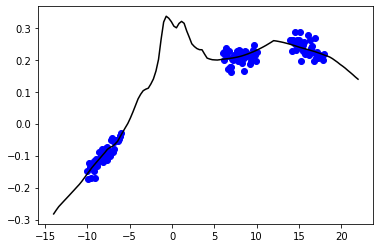

In [11]:
plt.plot(x, y, "bo")
plt.plot(x_, y_, "-k")

In [12]:
data = onp.savez(
    "synth_reg_data.npz",
    x_=onp.asarray(x_),
    y_=onp.asarray(y_),
    f_=onp.asarray(f_),
    x=onp.asarray(x),
    y=onp.asarray(y),
    f=onp.asarray(f)
)

In [ ]:
noise_var = 

log_prior_fn, log_prior_diff_fn = (
    nn_loss.make_gaussian_log_prior(weight_decay=0.1))